# Food 101

This notebook is a modified from lesson1-pets/fastai course to handle Food dataset. I got interested in this project because of my brother. He is so much focused on eating healthy food and its nutrient value http://www.21menus.com/. I think this project can help him in some ways.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import pandas as pd
import os
import numpy as np
from pathlib import Path

In [4]:
path = Path('/home/ubuntu/data/food-101/food-101')
SAMPLE = 100

In [5]:
train_df = pd.read_csv(path / 'meta/train.txt', header = None, names = ['name'])

In [6]:
test_df = pd.read_csv(path / 'meta/test.txt', header = None, names = ['name'])

In [7]:
train_df["test"] = 0
test_df["test"] = 1

In [8]:
df = pd.concat([train_df, test_df])

In [9]:
df['label'] = df['name'].str.split('/', expand = True)[0]


In [10]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the Food 101 data from https://www.vision.ee.ethz.ch/datasets_extra/food-101/ which features 101 food variety. Our model will need to learn to differentiate between these 101 distinct categories. 


In [11]:
path.ls()

[PosixPath('/home/ubuntu/data/food-101/food-101/images'),
 PosixPath('/home/ubuntu/data/food-101/food-101/license_agreement.txt'),
 PosixPath('/home/ubuntu/data/food-101/food-101/README.txt'),
 PosixPath('/home/ubuntu/data/food-101/food-101/meta')]

In [12]:
path_img = path/'images'

In [13]:
fnames = get_image_files(path_img, recurse=True)
fnames[:5]

[PosixPath('/home/ubuntu/data/food-101/food-101/images/breakfast_burrito/1840527.jpg'),
 PosixPath('/home/ubuntu/data/food-101/food-101/images/breakfast_burrito/1784404.jpg'),
 PosixPath('/home/ubuntu/data/food-101/food-101/images/breakfast_burrito/324140.jpg'),
 PosixPath('/home/ubuntu/data/food-101/food-101/images/breakfast_burrito/2398595.jpg'),
 PosixPath('/home/ubuntu/data/food-101/food-101/images/breakfast_burrito/403685.jpg')]

In [14]:
np.random.seed(2)

In [15]:
ds_tfms = get_transforms(flip_vert=True)

In [16]:
src = (ImageItemList.from_df(df, path=path_img, folder='.', suffix=".jpg", cols=0)
                .split_from_df(1)
                .label_from_df(sep=None, cols=2)
                .transform(ds_tfms, size=299)
                .databunch(bs=bs)
      )
data = src.normalize(imagenet_stats)

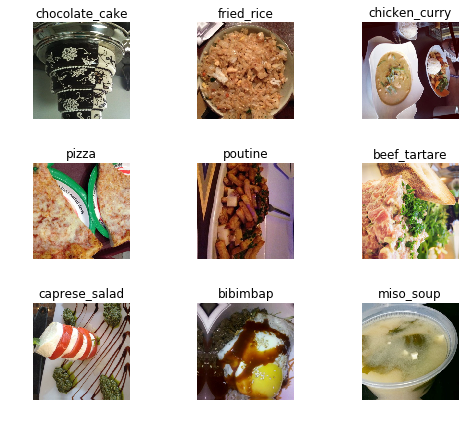

In [17]:
data.show_batch(rows=3, figsize=(7,6))

In [35]:
print(data.classes)
len(data.classes),data.c

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

(101, 101)

## Training: resnet50

We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. 

We will train for 4 epochs (4 cycles through all our data).

In [18]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.267666,1.093974,0.291287
2,1.298704,1.022921,0.273069
3,1.106219,0.941785,0.249967
4,0.983924,0.923004,0.247921


In [16]:
learn.save('stage-1')

In [16]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (60600 items)
[Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie]...
Path: /home/ubuntu/data/food-101/food-101/images
x: ImageItemList (60600 items)
[Image (3, 512, 308), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /home/ubuntu/data/food-101/food-101/images;

Valid: LabelList
y: CategoryList (15150 items)
[Category cheesecake, Category pad_thai, Category chicken_curry, Category hot_dog, Category cheesecake]...
Path: /home/ubuntu/data/food-101/food-101/images
x: ImageItemList (15150 items)
[Image (3, 512, 512), Image (3, 511, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /home/ubuntu/data/food-101/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

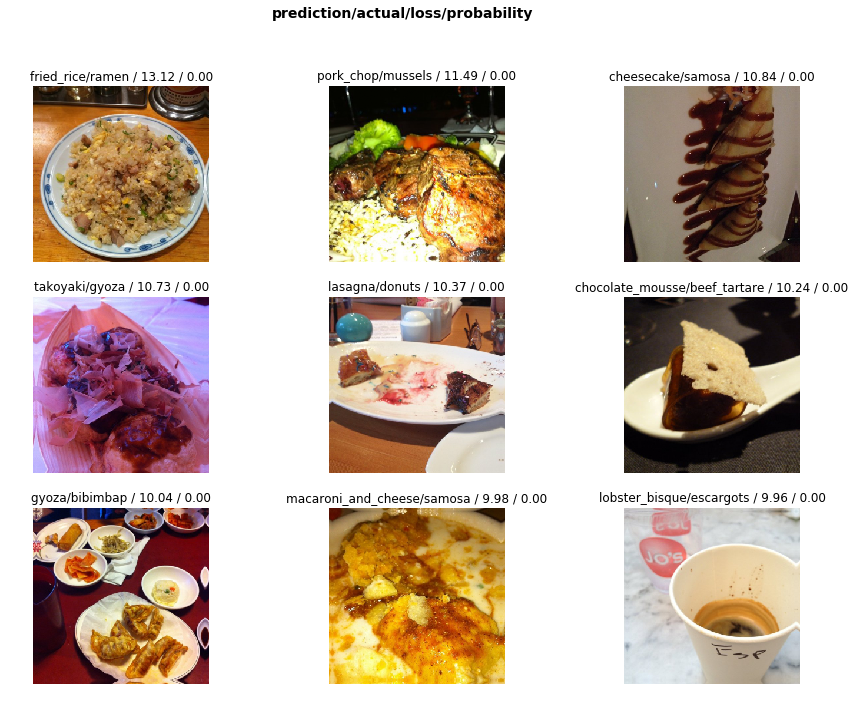

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

In [20]:
help(interp.plot_top_losses)

Help on method plot_top_losses in module fastai.vision.learner:

plot_top_losses(k, largest=True, figsize=(12, 12)) method of fastai.vision.learner.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of predicted class.



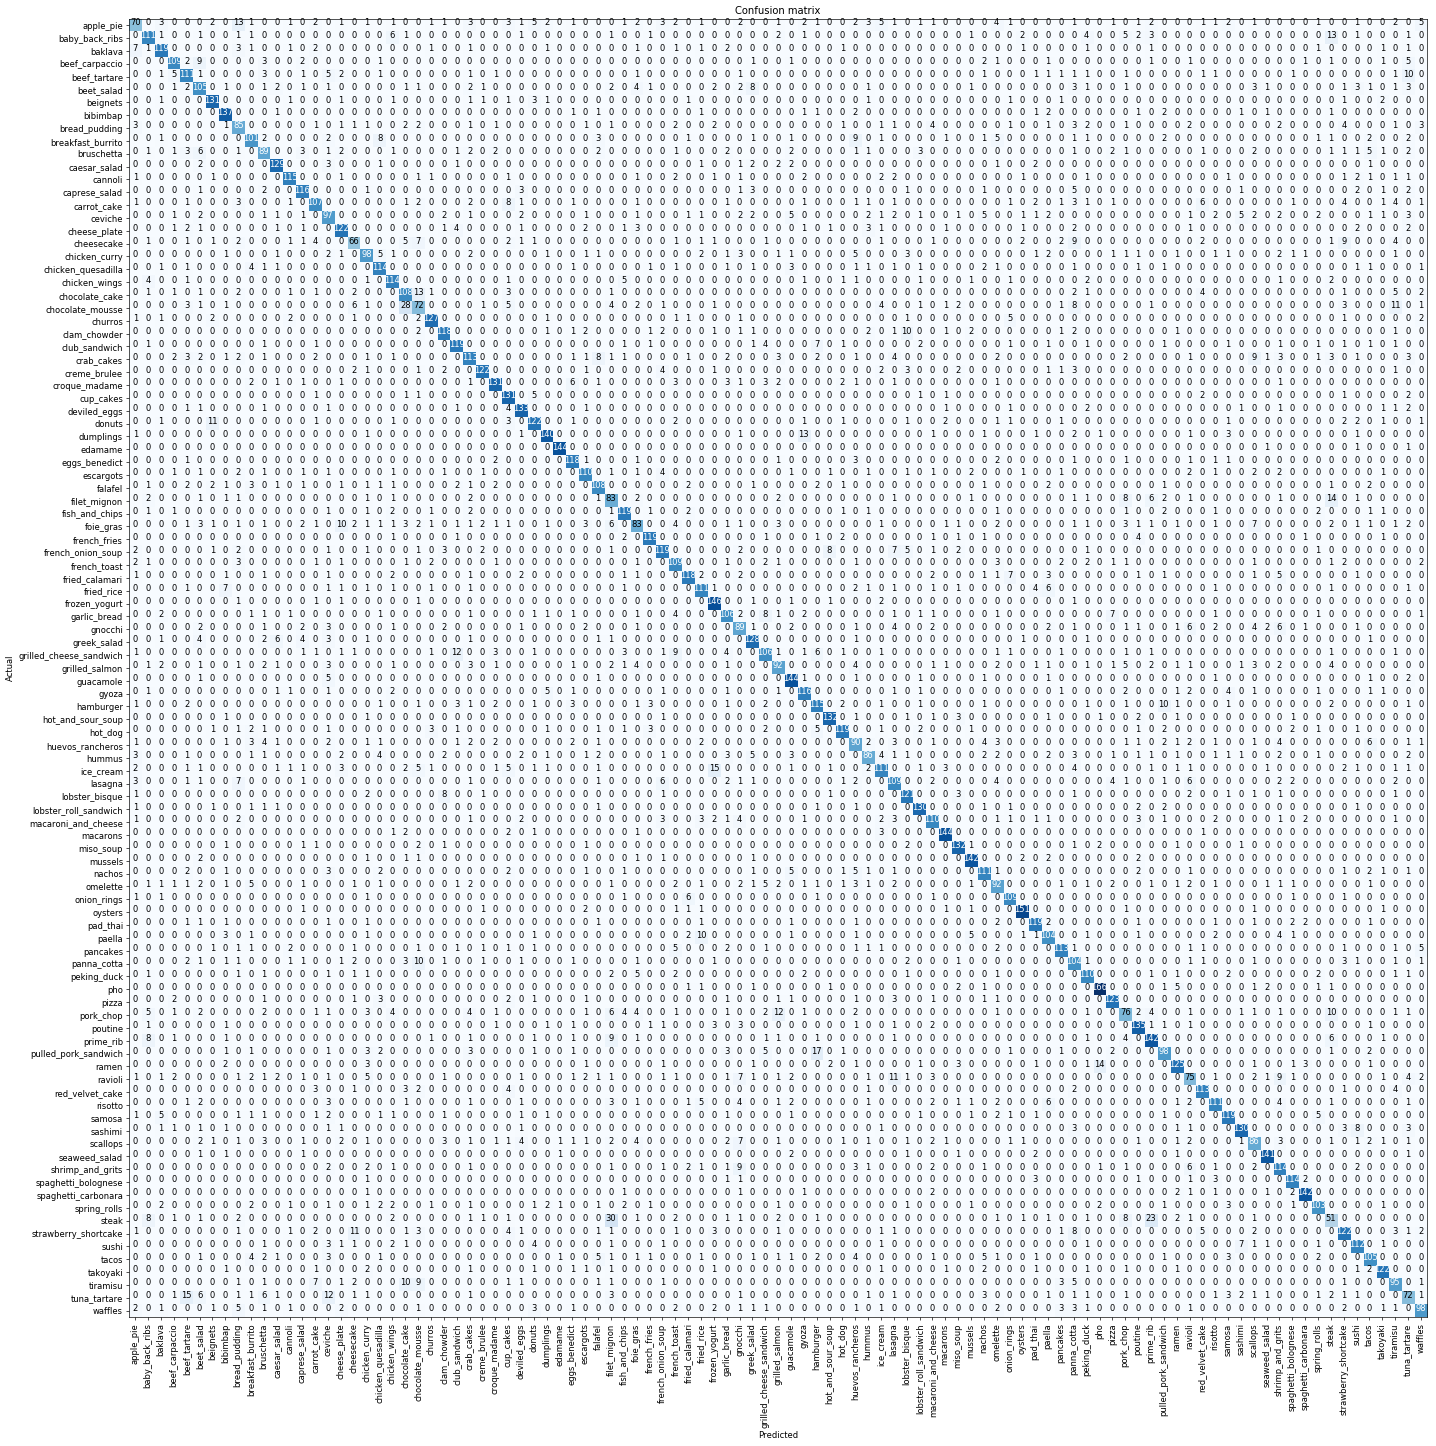

In [20]:
interp.plot_confusion_matrix(figsize=(24,24), dpi=60)

In [21]:
interp.most_confused(min_val=4)

[('steak', 'filet_mignon', 28),
 ('chocolate_mousse', 'chocolate_cake', 21),
 ('steak', 'prime_rib', 20),
 ('chocolate_cake', 'chocolate_mousse', 15),
 ('filet_mignon', 'steak', 15),
 ('grilled_cheese_sandwich', 'club_sandwich', 13),
 ('lobster_bisque', 'clam_chowder', 13),
 ('dumplings', 'gyoza', 12),
 ('ice_cream', 'frozen_yogurt', 12),
 ('panna_cotta', 'chocolate_mousse', 12),
 ('pulled_pork_sandwich', 'hamburger', 11),
 ('panna_cotta', 'cheesecake', 10),
 ('prime_rib', 'filet_mignon', 10),
 ('ravioli', 'lasagna', 10),
 ('steak', 'pork_chop', 10),
 ('tuna_tartare', 'beef_tartare', 10),
 ('apple_pie', 'bread_pudding', 9),
 ('breakfast_burrito', 'huevos_rancheros', 9),
 ('cheesecake', 'strawberry_shortcake', 9),
 ('filet_mignon', 'pork_chop', 9),
 ('pork_chop', 'filet_mignon', 9),
 ('spaghetti_bolognese', 'spaghetti_carbonara', 9),
 ('baby_back_ribs', 'steak', 8),
 ('beet_salad', 'greek_salad', 8),
 ('falafel', 'tacos', 8),
 ('foie_gras', 'scallops', 8),
 ('french_onion_soup', 'hot_an

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


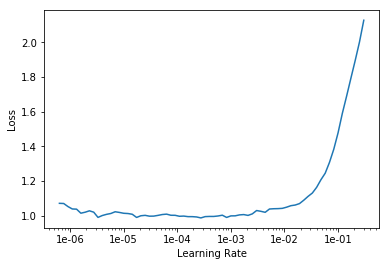

In [23]:
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate
1,1.139881,0.925112,0.251485
2,1.022137,0.831605,0.224158
3,0.677593,0.667799,0.181584
4,0.524097,0.625868,0.168779


In [25]:
learn.save("stage-2")

In [37]:
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (75750 items)
[Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie]...
Path: /home/ubuntu/data/food-101/food-101/images
x: ImageItemList (75750 items)
[Image (3, 512, 308), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /home/ubuntu/data/food-101/food-101/images;

Valid: LabelList
y: CategoryList (25250 items)
[Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie]...
Path: /home/ubuntu/data/food-101/food-101/images
x: ImageItemList (25250 items)
[Image (3, 512, 512), Image (3, 512, 384), Image (3, 512, 384), Image (3, 512, 382), Image (3, 342, 512)]...
Path: /home/ubuntu/data/food-101/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [38]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,0.877723,0.527037,0.151366
2,0.797047,0.487040,0.137980


In [39]:
learn.save('stage-3')

In [19]:
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (75750 items)
[Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie]...
Path: /home/ubuntu/data/food-101/food-101/images
x: ImageItemList (75750 items)
[Image (3, 512, 308), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /home/ubuntu/data/food-101/food-101/images;

Valid: LabelList
y: CategoryList (25250 items)
[Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie, Category apple_pie]...
Path: /home/ubuntu/data/food-101/food-101/images
x: ImageItemList (25250 items)
[Image (3, 512, 512), Image (3, 512, 384), Image (3, 512, 384), Image (3, 512, 382), Image (3, 342, 512)]...
Path: /home/ubuntu/data/food-101/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

### The training loss is still less than validation loss. So we run it for a few more cycles. I am going to stop it since we have reached out goal of 85% accuracy on the test set and it takes a long time.